In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import geopandas as gpd
import numpy as np

(2201466.728842696, 2251903.4973147013, 6440043.130753223, 6468528.844798662)

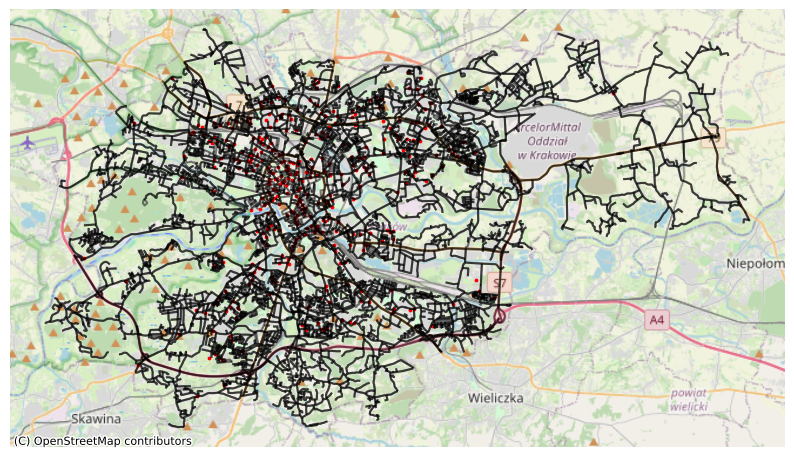

In [3]:
zabki_gdf = gpd.read_file('zabki_krakow.geojson')
zabki_gdf = zabki_gdf.to_crs(epsg=4326)
nearest_gdf = gpd.read_file('nearest.geojson')
neares_gdf = nearest_gdf.to_crs(epsg=4326)

import osmnx as ox

G = ox.graph_from_place('Kraków, Poland', network_type='drive')
# Utworzenie GeoDataFrame z ulicami 
streets_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)


#plot map of Krakow
import contextily as ctx
fig, ax = plt.subplots(figsize=(10, 10))
streets_gdf.to_crs(epsg=3857).plot(ax=ax, color='black', alpha=0.5, markersize=2)
zabki_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=1, markersize=3)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')

Finalna mapa Żabek i ulic w Krakowie

In [4]:
# Interaktywna mapa z ulicami, sklepami Żabka i najbliższymi punktami
import folium
from folium.plugins import MarkerCluster
import webbrowser

m = folium.Map(location=[50.0667, 19.9333], zoom_start=12)
marker_cluster = MarkerCluster().add_to(m)

for i, row in zabki_gdf.iterrows():
    folium.Marker(location=[row['lat'], row['lon']], popup='Żabka ID:' + '<br>' +str(row['id'])).add_to(marker_cluster)

for i, row in streets_gdf.iterrows():
    coords = list(row['geometry'].coords)
    locations = [(y, x) for x, y in coords]
    folium.PolyLine(locations=locations, color='black').add_to(m)

for i, row in nearest_gdf.iterrows():
    idx = row['id']
    nearest_point = row['geometry']
    folium.PolyLine(locations=[(zabki_gdf[zabki_gdf['id'] == idx]['lat'].values[0], zabki_gdf[zabki_gdf['id'] == idx]['lon'].values[0]),
                                (nearest_point.y, nearest_point.x)], color='red').add_to(m)
    
    folium.Marker(location=[nearest_point.y, nearest_point.x], popup='Nearest point to Żabka ID:' + '<br>' +str(row['id']) + '<br>' + 'Distance: ' + str(round(row['distance'], 2)) + ' m').add_to(m)


m.save('zabki_and_streets.html')
webbrowser.open('zabki_and_streets.html')

True

In [2]:
distance_matrix_df = pd.read_csv('distance_matrix.csv', index_col=0)
distance_matrix_straigt_line_df = pd.read_csv('distance_matrix_straight_line.csv', index_col=0)
path_matrix_df = pd.read_pickle('path_matrix_df.pkl')

# Szukanie najkrótszej trasy algorytmem genetycznym

In [3]:
# Zamieńmy wartości na km z dokładnością do metra
distance_matrix_df = distance_matrix_df / 1000
distance_matrix_df = distance_matrix_df.round(3)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [07:23<00:00,  2.26it/s]


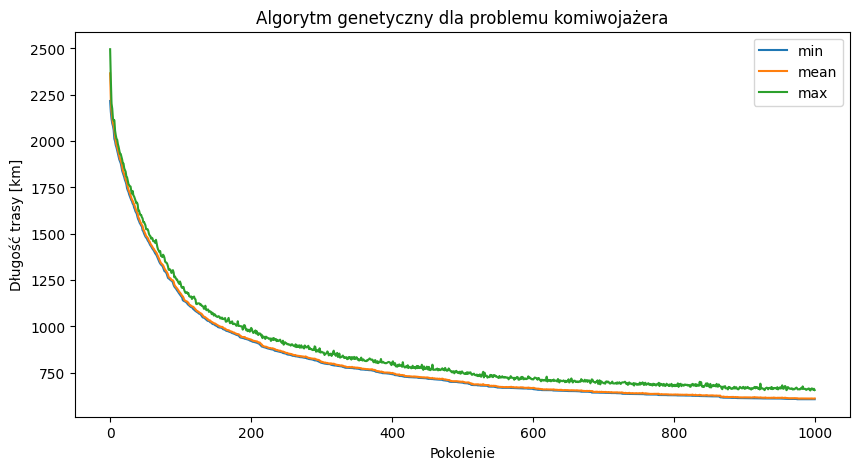

In [35]:
class TSP:
    def __init__(self, dist_matrix, pop_size=100, cxpb=0.5, mutpb=0.2, ngen=100):
        self.dist_matrix = dist_matrix # macierz odległości
        self.pop_size = pop_size # rozmiar populacji
        self.cxpb = cxpb # prawdopodobieństwo krzyżowania 
        self.mutpb = mutpb # prawdopodobieństwo mutacji
        self.ngen = ngen # liczba pokoleń
        self.size = dist_matrix.shape[0] # Rozmiar chromosomu
        self.best_ind = None # najlepsze rozwiązanie (trasa)
        self.best_ind_fitness = np.inf # wartość funkcji celu dla najlepszego rozwiązania (długość trasy)
        self.pop = self.init_pop()
        self.stats = pd.DataFrame(columns=['min', 'mean', 'max'], index=range(ngen))
        self.stats.index.name = 'gen'


    def init_pop(self):
        pop = np.zeros((self.pop_size, self.size), dtype=int)
        for i in range(self.pop_size):
            pop[i] = np.random.permutation(self.size) 
        return pop


    # def evaluate(self, ind):
    #     return np.sum([self.dist_matrix[ind[i], ind[i + 1]] for i in range(len(ind) - 1)]) # obliczenie długości trasy dla danego osobnika na podstawie macierzy odległości
    def evaluate(self, ind): # szybsza wersja funkcji oceny
        return np.sum(self.dist_matrix[ind, np.roll(ind, -1)])


    def cx(self, ind1, ind2):
        
        cx_point1 = np.random.randint(0, self.size)
        cx_point2 = np.random.randint(0, self.size - 1)

        if cx_point2 >= cx_point1:
            cx_point2 += 1
        else: # Swap the two cx points
            cx_point1, cx_point2 = cx_point2, cx_point1

        cutout = ind1[cx_point1:cx_point2].copy()
        ind1 = [x for x in ind2 if x not in cutout]
        ind1[cx_point1:cx_point1] = cutout
        return ind1, ind2


    def mutate(self, ind):
        mut_point1 = np.random.randint(0, self.size)
        mut_point2 = np.random.randint(0, self.size)
        ind[mut_point1], ind[mut_point2] = ind[mut_point2], ind[mut_point1]
        return ind
    
    
    def select(self, pop, fits):
        return pop[np.argsort(fits)]


    def evolve(self):
        for gen in tqdm.tqdm(range(self.ngen)):
            fits = np.array([self.evaluate(ind) for ind in self.pop])
            self.stats.loc[gen] = [np.min(fits), np.mean(fits), np.max(fits)]
            if np.min(fits) < self.best_ind_fitness:
                self.best_ind = self.pop[np.argmin(fits)].copy()
                self.best_ind_fitness = np.min(fits)
            next_pop = np.zeros_like(self.pop)
            for i in range(0, self.pop_size, 2):
                ind1, ind2 = self.select(self.pop, fits)[:2]
                if np.random.rand() < self.cxpb:
                    ind1, ind2 = self.cx(ind1, ind2)
                if np.random.rand() < self.mutpb:
                    ind1 = self.mutate(ind1)
                if np.random.rand() < self.mutpb:
                    ind2 = self.mutate(ind2)
                next_pop[i] = ind1
                next_pop[i + 1] = ind2
            self.pop = next_pop.copy()
        return self.best_ind, self.best_ind_fitness, self.stats


    def plot_stats(self):
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.lineplot(data=self.stats, x='gen' , y='min', label='min')
        sns.lineplot(data=self.stats, x='gen', y='mean', label='mean')
        sns.lineplot(data=self.stats, x='gen', y='max', label='max')
        plt.xlabel('Pokolenie')
        plt.ylabel('Długość trasy [km]')
        plt.title('Algorytm genetyczny dla problemu komiwojażera')
        plt.legend()
        plt.show()


tsp = TSP(distance_matrix_df.values, pop_size=1000, cxpb=0.5, mutpb=0.2, ngen=1000)
best_ind, best_ind_fitness, stats = tsp.evolve()
tsp.plot_stats()

In [36]:
print('Długość trasy:', best_ind_fitness, 'km')
print('Trasa:', best_ind)
stats

Długość trasy: 606.979 km
Trasa: [342 351 355  25 259 189 362 326 329 205  63 204 320 318 321  44  17 200
 313  10   9 349 112  41  48  47 194  38  43  61 110 139 174 315 187 221
  62  19 185 103  55 188 135 311 134 140  93 230 356 143 308 111  95  79
 233 231  60  87  24 343 254   7 186 340 264 236 198 234 322 118 102   4
 345 119 314 285 331 286 332 168 275 126 171 300 350 152 181 250  53 106
   6 214  27  26 104 260 301  90 293  49 211 347 179 199 289  11  37 253
  22 153 122  20 365 240 150  28 336  15  14 243 312 335   3  13 107 239
  84 366 251 359  85   5 248 338 232 306 265  54 367  97 145 339  12 348
 268  51 294  30 160 302 341 278  89 130  83 155 151 364 183  98 148 149
 297  39 262 238 284 223 330 235 217 354 138  16 273 316 272  73 216 137
 176 125 113  66 162  70  64  23 334 276 295 296 319 244 299  35 292  18
  32  40 228 219  45 218 368 280 279  36  34  65 177 212 178 246 225  33
 227 249 237  50 257 281   0  94 147 132 133 247 291 287 164 324 136 131
 114 210  91 357 3

,min,mean,max
gen,,,
0,2216.697,2365.939842,2495.957
1,2157.241,2224.345771,2331.021
2,2119.536,2161.09291,2201.193
3,2096.017,2124.859336,2175.525
4,2081.48,2096.829511,2121.337
...,...,...,...
995,606.979,611.117645,665.335
996,606.979,610.513221,662.951
997,606.979,610.25002,657.597


In [37]:
import collections

def validate_TSP_path(path):
    if len(path) != distance_matrix_df.shape[0]:
        print('Nie wszystkie punkty w trasie')
        return False
    #sprawdź czy są duplikaty
    if len(path) != len(set(path)):
        print('Duplikaty w trasie')
        print([item for item, count in collections.Counter(path).items() if count > 1])
        return False
    #sprawdź czy są punkty od 0 do n-1
    if set(path) != set(range(distance_matrix_df.shape[0])):
        print('Nie wszystkie punkty od 0 do n-1')
        return False
    
    return True


validate_TSP_path(best_ind)

True